In [258]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math, sys
import json
from scipy.interpolate import interp1d
import numpy as np
import json
from typing import Dict, List, Any, Optional, Literal


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


In [259]:
def get_dg_unit_params(R, L, Rt, Lt, Ct, Y, vdc, Be, Pl, vo):
  dgs_amount = len(Be)
  lines = len(Be[0])
  # Cálculo dos pontos de operação
  io = []
  for k in range(lines):
    _io = 0.
    for j in range(dgs_amount):
      _io += Be[j][k] * vo[j]
    io += [(1. / R[k]) * _io]

  # Corrente do indutor de cada unidade
  it_o = []
  for i in range(dgs_amount):
    _it_o = 0.
    for k in range(lines):
      _it_o += Be[i][k] * io[k]
    it_o += [(Y[i] * vo[i]) + (Pl[i] / vo[i]) + _it_o]

  # Duty cycles de operação
  d_o = []
  for i in range(dgs_amount):
    d_o += [(vo[i] / vdc[i]) + (Rt[i] / vdc[i]) * it_o[i]]

  # Create the dictionary of parameters
  params = {'R': R, 'L': L, 'Rt': Rt,  'Lt': Lt, 'Ct': Ct, 'Y': Y, 'vdc': vdc,
            'Be': Be, 'Pl': Pl, 'v_o': vo, 'i_o': io, 'it_o': it_o, 'd_o': d_o}

  return params

In [260]:
def get_A(ρ, params):

  Y = np.diag(params['Y'])
  L = np.diag(params['L'])
  R = np.diag(params['R'])
  vo = np.diag(params['v_o'])
  Be = np.array(params['Be'])
  Ct = np.diag(params['Ct'])
  Lt = np.diag(params['Lt'])
  Rt = np.diag(params['Rt'])

  dgs_amount = len(Be)

  # Obtenção dos parâmetros \rho
  ρ1 = np.diag(ρ[0:dgs_amount])
  ρ2 = np.diag(ρ[dgs_amount:2*dgs_amount])

  Ct_inv = np.linalg.inv(Ct)
  Lt_inv = np.linalg.inv(Lt)
  L_inv = np.linalg.inv(L)
  vo_inv = np.linalg.inv(vo)

  A11 = - Ct_inv @ Y + Ct_inv @ vo_inv @ ρ1 @ ρ2
  A12 = Ct_inv
  A13 = - Ct_inv @ Be
  A21 = - Lt_inv
  A22 = - Lt_inv @ Rt
  A23 = np.zeros((A22.shape[0], A13.shape[1]))
  A31 = L_inv @ Be.T
  A32 = np.zeros((A31.shape[0], A22.shape[1]))
  A33 = - L_inv @ R

  return np.block([[A11, A12, A13],
                   [A21, A22, A23],
                   [A31, A32, A33]])


def get_B(ρ, params):
  Lt = np.diag(params['Lt'])
  Lt_inv = np.linalg.inv(Lt)
  Be = np.array(params['Be'])

  dgs_amount = len(Be)
  lines = len(Be[0])

  vdc = np.diag(params['vdc'])
  B11 = np.zeros((dgs_amount, dgs_amount))
  B21 = - Lt_inv @ vdc
  B31 = np.zeros((lines, dgs_amount))
  return np.block([[B11],
                   [B21],
                   [B31]])

In [261]:
simulation_step = 1e-4
simulation_time = 0.5
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Entrada para simulação em malha aberta
u = np.zeros((len(timepts), 1))

# Conexões das linhas de potência (matriz de incidência: 6 DGs x 8 linhas)
Be = [[1.],
      [-1]]

dgs_amount = len(Be)
lines = len(Be[0])

# Resistências e indutâncias das 6 linhas de potência
R = [.5] * lines  # Ω
L = [1e-3] * lines  # H

# Parâmetros locais das 8 unidades
Rt = [1e-2] * dgs_amount          # Resistência em série do indutor (Ω)
Lt = [1e-3] * dgs_amount          # Indutância do filtro (H)
Ct = [2.2e-3] * dgs_amount        # Capacitância do filtro (F)
Y = [0.025] * dgs_amount            # Admitância (S)
vdc = [15, 19]    # Tensão de entrada (V)
Pl = [15, 24]  # Potência da CPL (W)
vo = [5., 9.]     # Tensão de operação dos capacitores (V)

# Obtém parâmetros das 8 unidades
dg_params = get_dg_unit_params(R, L, Rt, Lt, Ct, Y, vdc, Be, Pl, vo)

# Cálculo de u_bar para cada DG
u_bar = [min(1 - dg_params['d_o'][i], dg_params['d_o'][i])
         for i in range(dgs_amount)]

# Limites de perturbações de tensão
v_bounds = [[-3.5, 3.5]] * dgs_amount

ρ_bounds = np.array(
    [[1. / (vo[i] + v_bounds[i][1]), 1. / (vo[i] + v_bounds[i][0])]
     for i in range(dgs_amount)] +
    [[-5, 5]] * dgs_amount
)

display('rho_bounds', ρ_bounds)

# Limites do estado (ajustado para 8 DGs, exemplo com 5 variáveis de estado cada)
x_bounds = [(-3.5, 3.5),
            (-3.5, 3.5),
            (-4.0, 4.0),
            (-4.0, 4.0),
            (-3.0, 3.0)]

display(dg_params)

'rho_bounds'

array([[ 0.11764706,  0.66666667],
       [ 0.08      ,  0.18181818],
       [-5.        ,  5.        ],
       [-5.        ,  5.        ]])

{'R': [0.5],
 'L': [0.001],
 'Rt': [0.01, 0.01],
 'Lt': [0.001, 0.001],
 'Ct': [0.0022, 0.0022],
 'Y': [0.025, 0.025],
 'vdc': [15, 19],
 'Be': [[1.0], [-1]],
 'Pl': [15, 24],
 'v_o': [5.0, 9.0],
 'i_o': [-8.0],
 'it_o': [-4.875, 10.891666666666666],
 'd_o': [0.33008333333333334, 0.47941666666666666]}

In [262]:
Pl = [0] * dgs_amount

Pl[0] = Pl[0] + sgn.step_signal(timepts, [0.25], [4])
Pl[1] = Pl[1] + sgn.step_signal(timepts, [0.25], [-4])
# Pl[2] = Pl[2] + sgn.step_signal(timepts, [0.25], [15e3])
# Pl[3] = Pl[3] + sgn.step_signal(timepts, [0.25], [-15e3])

In [263]:
def plant_dynamics(time, x, inputs, params):
  # Extracting the number of inputs and parameters
  n_u = dgs_amount
  n_p = 2 * dgs_amount

  # Splitting inputs into u (control inputs) and p (parameters)
  u = inputs[0:n_u][:].reshape(-1, 1)
  ρ = inputs[n_u:n_u + n_p][:].flatten()

  # Getting the system matrices A and B
  A = get_A(ρ, params)
  B = get_B(ρ, params)

  # Computing the time derivative of the state
  # s (x_dot)
  x_dot = A @ x + B @ u

  return x_dot


def plant_output(t, x, u, params):
  return x

## Simulação da Planta em Malha Aberta

In [264]:
def openloop_simulation(x0, plant_dynamics, plant_output,
                        timepts, T_s, params):
  """
  Simula um sistema de controle em malha aberta com integração RK5.

  Args:
      x0 (np.ndarray): Estado inicial, shape (n, 1)
      plant_dynamics (callable): Dinâmica do sistema f(t, x, u, params)
      plant_output (callable): Função de saída h(t, x, u, params)
      u_til (np.ndarray): Entradas estendidas, shape (N, m, 1)
      timepts (np.ndarray): Vetor de instantes de tempo, shape (N,)
      T_s (float): Passo de simulação
      params (dict): Parâmetros do sistema

  Returns:
      list[np.ndarray]: Lista com N+1 elementos, cada um de shape (n_y, 1),
                        contendo a saída em cada instante.
  """
  N = len(timepts)
  n = x0.shape[0]

  # Inicialização do estado
  x = np.zeros((n, N, 1))
  x[:, 0, :] = x0

  outputs = []

  for k, t in enumerate(timepts):
    _x = x[:, k, :].flatten()

    control_input = [u[k][0]] * dgs_amount
    ρ1 = [1. / (vo[i] + _x[i]) for i in range(dgs_amount)]
    ρ2 = [v[k] for v in Pl]

    inputs = np.hstack((control_input, ρ1, ρ2))
    outputs.append(plant_output(t, x[:, k, :], inputs, dg_params))

    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(
          plant_dynamics, t, x[:, k, :], inputs, T_s, dg_params
      )

  return outputs

In [265]:
x0 = np.array([[1], [1], [1], [1], [1]])
outputs = openloop_simulation(x0, plant_dynamics, plant_output,
                              timepts, simulation_step, dg_params)

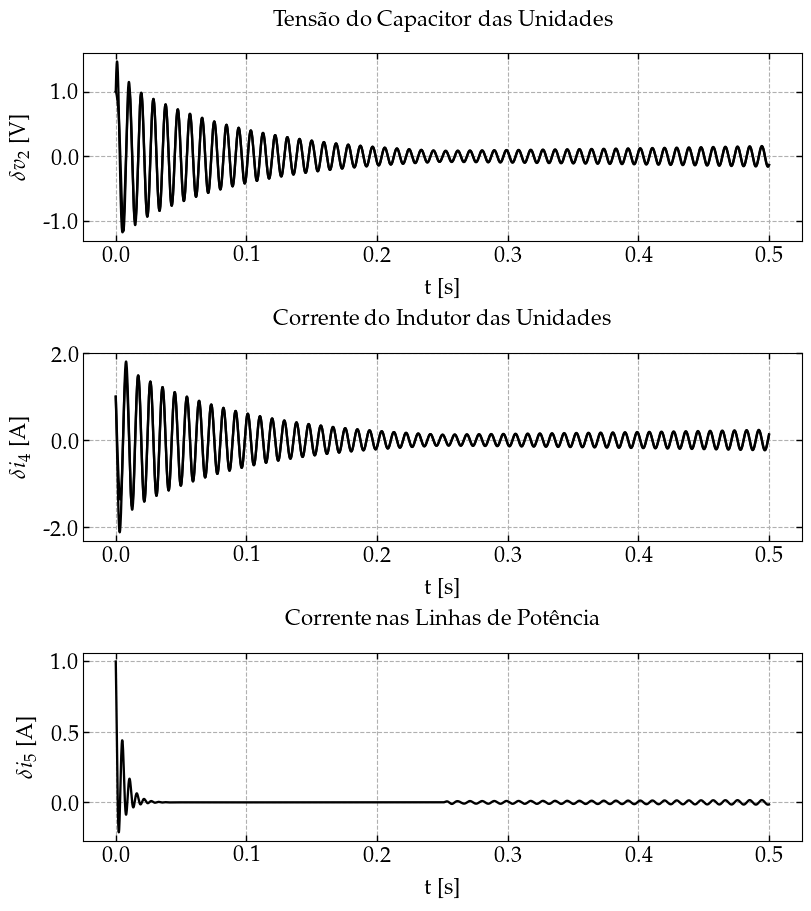

In [266]:
fig = plt.figure(figsize=(8, 9), layout='constrained')

mosaic = [['δv'], ['δit'], ['δi']]
axs = fig.subplot_mosaic(mosaic)

for i in range(dgs_amount):
  gph.plot(axs[mosaic[0][0]], timepts, [v[i] for v in outputs],
           't [s]', f'$\\delta v_{i+1}$ [V]',
           f'Tensão do Capacitor das Unidades',)
for i in range(dgs_amount, 2 * dgs_amount):
  gph.plot(axs[mosaic[1][0]], timepts, [v[i] for v in outputs],
           't [s]', f'$\\delta i_{i+1}$ [A]',
           f'Corrente do Indutor das Unidades',)
for i in range(2 * dgs_amount, 2 * dgs_amount + lines):
  gph.plot(axs[mosaic[2][0]], timepts, [v[i] for v in outputs],
           't [s]', f'$\\delta i_{i+1}$ [A]',
           f'Corrente nas Linhas de Potência',)
# plt.tight_layout()

In [267]:
def solve_problem(
    h: float,
    ε: Optional[float] = None,
    μ: Optional[float] = None,
    ρ: Optional[float] = None,
    γ: Optional[float] = None,
    eps: float = 1e-6
):
  n_u = dgs_amount
  n_p = 2 * dgs_amount
  n_x = 2 * dgs_amount + lines

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))

  A = {}
  B = {}

  for i in Bnp:
    ρi = [ρ_bounds[idx][i[idx]] for idx in range(n_p)]
    A[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=get_A(ρi, dg_params))
    B[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=get_B(ρi, dg_params))

  v = nm.get_e(7 * [n_x])

  for i in range(1, len(v)):
    v[i] = cp.Parameter(v[i].shape, value=v[i], name=f"e{i}")

  ℓ = nm.get_e(4 * [n_x])

  for i in range(1, len(ℓ)):
    ℓ[i] = cp.Parameter(ℓ[i].shape, value=ℓ[i], name=f"l{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), symmetric=True)
  Stil = cp.Variable((n_x, n_x), symmetric=True)
  Util = cp.Variable((n_x, n_x))

  Qtil = cp.Variable((n_x, n_x), PSD=True)
  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), symmetric=True)
  Ktil = cp.Variable((n_u, n_x), name=f'K')

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  ρ = cp.Parameter(value=ρ, name='ρ')
  μ = cp.Parameter(value=μ, name='μ')
  ε = cp.Parameter(value=ε, name='λ')
  φ = cp.Variable(pos=True)

  X = cp.Variable((n_x, n_x))
  Y1til = cp.Variable((2 * n_x, 2 * n_x))
  Y2til = cp.Variable((2 * n_x, 2 * n_x))

  Pcal = cp.bmat([[Ptil,   Util],
                  [Util.T, Stil]])

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Xεtil = v[1].T + ε * v[2].T + ε * v[3].T

  G1 = {}
  G1['0'] = cp.bmat([[v[1]], [h * v[6]]])
  G1['h'] = cp.bmat([[v[1]], [h * v[5]]])

  G0 = cp.bmat([[v[2]], [v[1] - v[4]]])

  Ω = cp.bmat([[v[1] - v[3]],
              [v[1] + v[3] - 2 * v[5]],
              [v[3] - v[4]],
              [v[3] + v[4] - 2 * v[6]]])

  O2nx = np.zeros((2 * n_x, 2 * n_x))

  def get_Υ(i):
    Ftil = A[i] @ X @ v[1] - X @ v[2] + B[i] @ Ktil @ v[3] + B[i] @ Ktil @ v[7]

    Θtil = {}
    Θtil['0'] = nm.He(G1['0'].T @ Pcal @ G0) + v[1].T @ Qtil @ v[1] - \
        v[4].T @ Qtil @ v[4] + (h ** 2) * v[2].T @ Rtil @ v[2] - \
        v[7].T @ Ξtil @ v[7] + nm.He(Xεtil @ Ftil)

    Θtil['h'] = nm.He(G1['h'].T @ Pcal @ G0) + v[1].T @ Qtil @ v[1] - \
        v[4].T @ Qtil @ v[4] + (h ** 2) * v[2].T @ Rtil @ v[2] - \
        v[7].T @ Ξtil @ v[7] + nm.He(Xεtil @ Ftil)

    Φtil = {}

    Φtil1 = cp.bmat([[Rcal, O2nx],
                    [O2nx, Rcal]])
    Φtil2 = cp.bmat([[Rcal, Y2til], [Y2til.T, O2nx]])
    Φtil3 = cp.bmat([[O2nx, Y1til], [Y1til.T, Rcal]])

    Φtil['0'] = Φtil1 + Φtil2
    Φtil['h'] = Φtil1 + Φtil3

    Γ1_11 = Θtil['0'] - Ω.T @ Φtil['0'] @ Ω
    Γ1_12 = Ω.T @ cp.bmat([[Y1til], [O2nx]])
    Γ1_13 = v[3].T @ X.T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Rcal
    Γ1_23 = np.zeros((2 * n_x, n_x))

    Γ1_31 = Γ1_13.T
    Γ1_32 = Γ1_23.T
    Γ1_33 = - Ψtil

    Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13],
                  [Γ1_21, Γ1_22, Γ1_23],
                  [Γ1_31, Γ1_32, Γ1_33],])

    Γ2_11 = Θtil['h'] - Ω.T @ Φtil['h'] @ Ω
    Γ2_12 = Ω.T @ cp.bmat([[O2nx], [Y2til.T]])
    Γ2_13 = v[3].T @ X.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13],
                  [Γ2_21, Γ2_22, Γ2_23],
                  [Γ2_31, Γ2_32, Γ2_33],])

    return Γ1, Γ2

  for i in Bnp:
    Υ1, Υ2 = get_Υ(i)
    constraints += [Υ1 << -eps * np.eye(Υ1.shape[0])]
    constraints += [Υ2 << -eps * np.eye(Υ2.shape[0])]

  aq = nm.get_vertices(x_bounds)

  β = μ + cp.exp(2. * ρ * 0)

  for i in range(len(aq)):
    LMI_D11 = np.eye(1)
    LMI_D12 = aq[i].T @ X
    LMI_D21 = LMI_D12.T
    LMI_D22 = (1. / β) * Ptil

    LMI_D = cp.bmat([[LMI_D11, LMI_D12],
                     [LMI_D21, LMI_D22]])

    constraints += [LMI_D >> 0]

  η0 = 0.

  LMID0_11 = φ * (1. - (η0 / β)) * np.eye(n_x)
  LMID0_12 = np.eye(n_x)
  LMID0_21 = np.eye(n_x)
  LMID0_22 = X + X.T - Ptil

  LMID0 = cp.bmat([[LMID0_11, LMID0_12],
                   [LMID0_21, LMID0_22]])

  constraints += [LMID0 >> 0]

  H0 = cp.bmat([[ℓ[2]], [ℓ[1] - ℓ[3]]])
  H1 = cp.bmat([[ℓ[1]], [h * ℓ[4]]])
  H2 = cp.bmat([[ℓ[1] - ℓ[3]], [ℓ[1] + ℓ[3] - 2. * ℓ[4]]])

  Zεtil = ℓ[1].T + ε * ℓ[2].T + ε * ℓ[3].T

  for i in Bnp:
    Jtil = A[i] @ X @ ℓ[1] - X @ ℓ[2]

    Λ = nm.He(H1.T @ Pcal @ H0) + ℓ[1].T @ Qtil @ ℓ[1] - ℓ[3].T @ Qtil @ ℓ[3] + (h ** 2) \
        * ℓ[4].T @ Rtil @ ℓ[4] - nm.He(H2.T @ Rcal @ H2) + nm.He(Zεtil @ Jtil) \
        - 2. * ρ * ℓ[1].T @ Ptil @ ℓ[1]

    Π12 = ℓ[3].T @ X.T
    Π21 = X @ ℓ[3]
    Π22 = - Ψtil

    Π = cp.bmat([[Λ, Π12],
                 [Π21, Π22]])

    constraints += [Π << -eps * np.eye(Π.shape[0])]

  constraints += [μ * Ptil - (h ** 2) * Stil - h *
                  (Qtil + Util + Util.T) >> 0.]
  constraints += [Ξtil >> eps * np.eye(n_x)]
  constraints += [Ψtil >> eps * np.eye(n_x)]
  constraints += [Pcal >> eps * np.eye(Pcal.shape[0])]
  # constraints += [cp.trace(Ξtil + Ψtil) <= γ]

  for i in Bnp:
    LMI_11 = - 2.0 * ρ * Ptil + nm.He(A[i] @ X)
    LMI_21 = Ptil - X.T + ε * A[i] @ X
    LMI_12 = LMI_21.T
    LMI_22 = - ε * nm.He(X)

    LMI = cp.bmat([[LMI_11, LMI_12],
                   [LMI_21, LMI_22]])

    constraints += [LMI << -eps * LMI.shape[0]]

  # constraints += [φ >= eps]

  obj = cp.Minimize(φ)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)
  # prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True,
  #            mosek_params={
  #                # Aumentar precisão
  #                'MSK_DPAR_INTPNT_TOL_REL_GAP': 1e-6,
  #                'MSK_DPAR_INTPNT_TOL_PFEAS': 1e-6,
  #                'MSK_DPAR_INTPNT_TOL_DFEAS': 1e-6,
  #                # Mais iterações permitidas
  #                'MSK_IPAR_INTPNT_MAX_ITERATIONS': 400,
  #                # Evitar parada prematura
  #                'MSK_DPAR_INTPNT_CO_TOL_MU_RED': 1e-6,
  #                # Log detalhado
  #                'MSK_IPAR_LOG': 10
  #            })

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    # print("Optimal value: %s\n" % prob.value)

    # matrix_utils.show_matrix(Ξtil.value, 'Ξtil')

    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)

    # matrix_utils.show_matrix(Xinv.T @ Ξtil.value)

    # matrix_utils.show_matrix(X.value, 'X')

    P = Xinv.T @ Ptil.value @ Xinv
    M = Xinv.T @ Util.value @ Xinv
    S = Xinv.T @ Stil.value @ Xinv
    Q = Xinv.T @ Qtil.value @ Xinv
    R = Xinv.T @ Rtil.value @ Xinv

    Pcal_ = np.block([[P, M], [M.T, S]])

    error = False

    if nm.matrix_definiteness(P) != 'pd' or \
       nm.matrix_definiteness(S) != 'pd' or \
       nm.matrix_definiteness(Pcal_) != 'pd':
      error = True

    if not error:
      K = Ktil.value @ Xinv

      design_results = {
          'optimal_value': prob.value,
          'etm': {'Ξ': Ξ, 'Ψ': Ψ},
          'controller': {'K': K, 'L': L},
          'lyapunov': {'P': P, 'M': M, 'S': S, 'Q': Q, 'R': R},
          'bounds': {'β': β.value, 'ρ': ρ.value}
      }
  else:
    design_results = None

  return design_results

In [268]:
# Definição inicial das variáveis
Ξ = Ψ = K = L1 = P = γ = β = None
θ1, Θ2, ε = None, None, None

# Parâmetros e resolução do problema
h, υ, ρ, μ, γ = 1e-4, 1e-5, 1e0, 1e-5, 1e-1

prob_res = solve_problem(h=h, ε=υ, μ=μ, ρ=ρ, γ=γ, eps=1e-6)

if prob_res is not None:
  Ξ = prob_res['etm']['Ξ']
  Ψ = prob_res['etm']['Ψ']
  K = prob_res['controller']['K']
  L = prob_res['controller']['L']
  P = prob_res['lyapunov']['P']
  M = prob_res['lyapunov']['M']
  S = prob_res['lyapunov']['S']
  Q = prob_res['lyapunov']['Q']
  R = prob_res['lyapunov']['R']
  # ρ = prob_res['bounds']['ρ']
  β = prob_res['bounds']['β']

  print('Resultados:')
  display(Math(rf'f^\star =' + tex.dec2tex(prob_res['optimal_value'])))
  display(Math(rf'\beta =' + tex.dec2tex(β)))
  # display(Math(rf'\rho =' + tex.dec2tex(ρ)))
  display(Math(rf'x^\top(t) P x(t) \preceq' + tex.dec2tex(1. / β)))

  # display(Math(rf'P = ' + dp.mat2tex(P)))

  print('Matrizes de Acionamento:')
  display(Math(rf'\Xi = ' + tex.mat2tex(Ξ)))
  display(Math(rf'\Psi = ' + tex.mat2tex(Ψ)))

  print('Matrizes de Controle:')
  Bnp = list(itertools.product([0, 1], repeat=2))
  display(Math(rf'K = ' + tex.mat2tex(K)))
else:
  print('Problema não é factível!')

Problema não é factível!


In [131]:
def closedloop_simulation(x0, η0, θ, λ, T_s):
  # Conversão inicial para float32
  x0 = np.array(x0, dtype=np.float32)
  η0 = np.array(η0, dtype=np.float32)
  T_s = np.float32(T_s)

  print("x0.T @ P @ x0", (x0.T @ P @ x0).item())

  if (x0.T @ P @ x0).item() > 1.1:
    raise ValueError(
        "O estado inicial x0 não pertence à região de estados iniciais estimada. "
        "A simulação será interrompida pois os resultados não são garantidos."
    )

  N = len(timepts)
  nx = x0.shape[0]

  # Pré-alocação dos vetores principais
  x = np.zeros((nx, N + 1, 1), dtype=np.float32)
  η = np.zeros((N + 1, 1), dtype=np.float32)
  σ = np.zeros((N + 1, 1), dtype=np.float32)

  x[:, 0, :] = x0
  η[0, :] = η0

  y = []
  uc = []

  x_hat = x0.copy()
  xτ = x0.copy()

  next_time_sampling = np.float32(h)
  event_times = [np.float32(0.0)]

  # --- Funções internas ---
  def triggering_condition(_xτ, _ε, _η):
    Γ = (_xτ.T @ Ξ @ _xτ) - (_ε.T @ Ψ @ _ε)
    return (_η + θ * Γ) < np.float32(0)

  def etm_dynamics(t, _η, _σ, params):
    ε = x_hat - xτ
    Γ = (xτ.T @ Ξ @ xτ) - (ε.T @ Ψ @ ε)
    η_dot = - λ * _η + Γ[0][0]
    return np.float32(η_dot)

  def control_signal():
    uc_k = np.float32(K @ x_hat)
    return np.array([sgn.sat(uc_k[i, 0], u_bar[i]) for i in range(len(uc_k))], dtype=np.float32)

  # --- Laço principal ---
  for k, t in enumerate(timepts):
    t = np.float32(t)

    # Verificação da condição de acionamento
    if t >= next_time_sampling:
      next_time_sampling += np.float32(h)
      xτ = x[:, k, :].astype(np.float32)
      ε = (x_hat - xτ).astype(np.float32)
      new_event = triggering_condition(xτ, ε, η[k, :])
      if new_event:
        x_hat = xτ
        event_times.append(float(t))

    x_k = x[:, k, :].flatten().astype(np.float32)

    # Cálculo do sinal de controle
    u_sat = control_signal()

    # Parâmetros variantes
    ρ1 = np.array([1.0 / (vo[i] + x_k[i])
                  for i in range(dgs_amount)], dtype=np.float32)
    ρ2 = np.array([v[k] for v in Pl], dtype=np.float32)
    inputs = np.hstack((u_sat, ρ1, ρ2)).astype(np.float32)

    # Saída da planta
    y.append(plant_output(t, x[:, k, :].astype(
        np.float32), inputs, dg_params))
    uc.append(u_sat)

    # Integração numérica
    if k < N:
      x[:, k + 1, :] = nm.rk5_step(
          plant_dynamics, t, x[:, k, :].astype(
              np.float32), inputs, T_s, dg_params
      ).astype(np.float32)

      η[k + 1, :] = nm.rk5_step(etm_dynamics, t, η[k, :],
                                σ[k, :], T_s, None).astype(np.float32)

  return y, uc, σ[:N], η[:N], event_times

In [ ]:
import numpy as np


def sample_ellipsoid_boundary(P, n_points=1000, seed=None):
  """
  Gera pontos na fronteira da elipsoide x.T P x = 1.
  P deve ser simétrica definida positiva (SPD).

  Parâmetros
  ----------
  P : ndarray (n, n)
      Matriz simétrica definida positiva.
  n_points : int
      Número de pontos a gerar.
  seed : int ou None
      Semente para o gerador aleatório. Se None, uma nova seed aleatória é criada.

  Retorna
  -------
  x_boundary : ndarray (n, n_points)
      Pontos na fronteira da elipsoide.
  seed : int
      Seed usada na geração (útil para reprodutibilidade).
  """
  n = P.shape[0]

  # define a seed
  if seed is None:
    seed = np.random.randint(0, 2**16 - 1)
  rng = np.random.default_rng(seed)

  # decomposição de Cholesky
  L = np.linalg.cholesky(P)

  # amostragem na esfera unitária
  x = rng.standard_normal((n, n_points))
  x /= np.linalg.norm(x, axis=0, keepdims=True)

  # transformação para a elipsoide
  x_boundary = np.linalg.solve(L.T, x)

  return x_boundary, seed


x0_list, seed_used = sample_ellipsoid_boundary(P, n_points=20, seed=5308)

print("Seed usada:", seed_used)

In [153]:
import os
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# -----------------------------
# Funções auxiliares
# -----------------------------


def convert_to_serializable(obj):
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  elif isinstance(obj, list):
    return [convert_to_serializable(item) for item in obj]
  elif isinstance(obj, dict):
    return {key: convert_to_serializable(val) for key, val in obj.items()}
  return obj


def convert_to_numpy(obj):
  return {
      'trajectories': [np.array(y_k) for y_k in obj['trajectories']],
      'control-signal': [np.array(u_k) for u_k in obj['control-signal']],
      'sigma': [np.array(sigma_k) for sigma_k in obj['sigma']],
      'eta': [np.array(eta_k) for eta_k in obj['eta']],
      'inter-event-times': obj['inter-event-times'],
  }

# -----------------------------
# Função de simulação
# -----------------------------


def get_trajectories(i):
  i = 19
  # idx = i % x0_list.shape[1]
  # x0 = x0
  η0 = np.array([[0.]])
  Θ = 0.10010005001667084
  λ = 10

  # closedloop_simulation precisa estar definido globalmente
  y, uc, σ, η, event_times = closedloop_simulation(
      x0, η0, Θ, λ, T_s=simulation_step
  )
  inter_event_times = np.diff(event_times).tolist()

  return {
      'trajectories': y,
      'sigma': σ,
      'eta': η,
      'control-signal': uc,
      'inter-event-times': inter_event_times
  }


# -----------------------------
# Configurações
# -----------------------------
experiment_name = "Results/Notebook-05/ClosedLoop_Results.json"
force_simulation = True
simulations_amount = 1

results_clsim = {
    'inter-event-times': [],
    'control-signal': [],
    'trajectories': [],
    'sigma': [],
    'eta': [],
}

# -----------------------------
# Carregar ou simular
# -----------------------------
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    loaded = json.load(f)
    results_clsim = convert_to_numpy(loaded)
else:
  print("Executando simulações...")

  # ThreadPoolExecutor funciona de forma segura em notebooks
  with ThreadPoolExecutor() as executor:
    results = list(executor.map(
        get_trajectories, range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])
    results_clsim['control-signal'].append(res['control-signal'])
    results_clsim['sigma'].append(res['sigma'])
    results_clsim['eta'].append(res['eta'])

  # Salvar resultados
  results_serializable = convert_to_serializable(results_clsim)
  os.makedirs(os.path.dirname(experiment_name), exist_ok=True)
  with open(experiment_name, "w") as f:
    json.dump(results_serializable, f, indent=2)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

Executando simulações...
x0.T @ P @ x0 0.4300635855914798
Simulações concluídas. Resultados salvos em Results/Notebook-05/ClosedLoop_Results.json.


Estado Inicial:  [1. 1. 1. 1. 1.]
Número de amostras dos estados:  5000
Número de transmissões de estados realizados:  0


c:\Users\andel\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\andel\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\andel\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\andel\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\andel\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

ValueError: min() iterable argument is empty

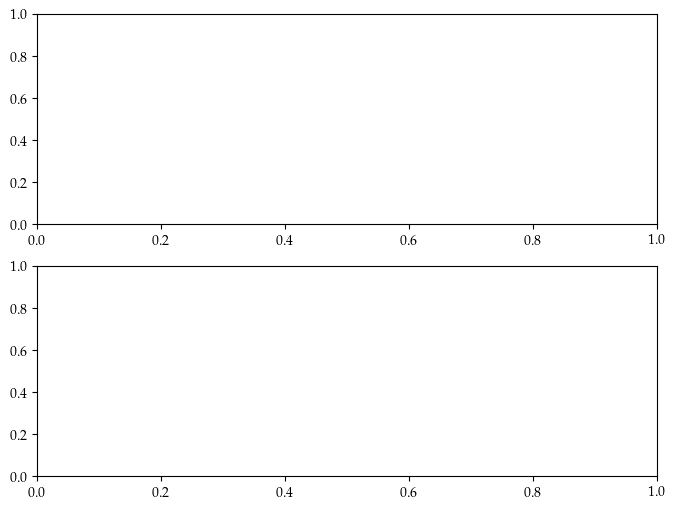

In [154]:
%matplotlib inline

cfg = {
    'style': { 'color': 'black', 'linewidth': 2.},
    'axis': { 'title_pad': 10, 'y_digits': 1, 'x_digits': 0,
              'x_label_fontsize': 20,
              'y_label_fontsize': 20,
              'tick_fontsize': 20,},
    'limits': { 'x_min': 0., 'x_max': simulation_time * 1e3,}
  }

simulation_index = 0
inter_event_times = results_clsim['inter-event-times'][simulation_index]
uc = results_clsim['control-signal'][simulation_index]
y = results_clsim['trajectories'][simulation_index]
_σ = results_clsim['sigma'][simulation_index]
η = results_clsim['eta'][simulation_index]
event_times = np.cumsum(inter_event_times)

mosaic = [['σ'], ['η']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 6))

t_formatted, t_unit_label, t_decimal_places = nm.format_magnitudes(
    timepts, 's', use_prefixes=True, n_divs=5)

axis_limits = {'x_min': 0., 'x_max': timepts[-1]}

# Estatísticas adicionais do tempo entre eventos
std_iet = np.std(inter_event_times)                     # Desvio-padrão
cv_iet = std_iet / np.mean(inter_event_times)           # Coeficiente de variação (adimensional)
event_rate = len(inter_event_times) / timepts[-1]       # Taxa média de acionamentos [eventos/s]

print("Estado Inicial: ", y[0].reshape(-1))
print("Número de amostras dos estados: ", int(simulation_time / 0.1e-3))
print("Número de transmissões de estados realizados: ", len(inter_event_times))
print("Menor IET Obtido: ", min(inter_event_times))
print("Máximo IET Obtido: ", max(inter_event_times))
print("Média do Intervalos de Tempo entre Eventos: ", np.mean(
      inter_event_times) )

print("Desvio-padrão dos IETs: ", std_iet)
print("Coeficiente de variação dos IETs: ", cv_iet)
print("Taxa média de acionamentos: ", event_rate, "eventos/s")

σ_f, σ_ul, σ_dp = nm.format_magnitudes(
    _σ, '', use_prefixes=False, n_divs=4)

gph.plot(
    axs['σ'], t_formatted, σ_f,
    xlabel='$t$ [s]', ylabel='$\\sigma(t)\\,$' + σ_ul,
    title='',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places, 'y_digits': 0},
        'limits': { **cfg['limits'], **axis_limits },
      })

n_f, n_ul, n_dp = nm.format_magnitudes(
    η, '', use_prefixes=False, n_divs=5)

gph.plot(
    axs['η'], t_formatted, n_f,
    xlabel='$t$ [s]', ylabel='$\\eta(t)\\,$' + n_ul,
    # title='Variável dinâmica do ETM',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places, 'y_digits': 0},
        'limits': { **cfg['limits'], **axis_limits },
      })

plt.tight_layout(pad=1.)

# Diretório e nome do arquivo
file_path = r"P:\Papers\PETC_for_Microgrids\Figs\sigma_eta_behavior.eps"
fig.savefig(file_path, format='eps', bbox_inches='tight', dpi=600)

Failed to find a Ghostscript installation.  Distillation step skipped.


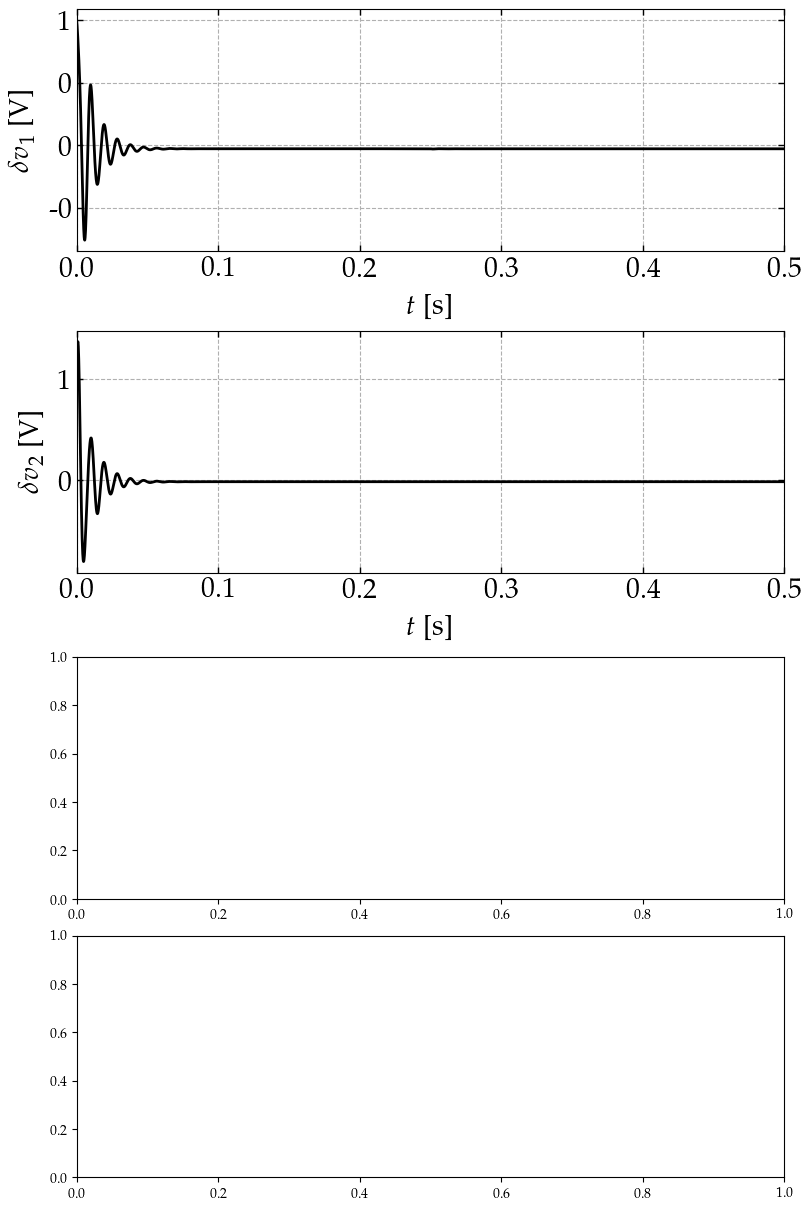

In [155]:
fig = plt.figure(figsize=(8, 12), layout='constrained')

mosaic = [['δv1'], ['δv2'], ['δv3'], ['δv4']]
axs = fig.subplot_mosaic(mosaic)

for i in range(dgs_amount):
  gph.plot(axs[f'δv{i+1}'], timepts, [v[i] for v in y],
           '$t$ [s]', f'$\\delta v_{i+1}$ [V]',
           plot_cfg={**cfg,
                     'style': {**cfg['style']},
                     'axis': {**cfg['axis'], 'x_digits': t_decimal_places, 'y_digits': 0},
                     'limits': {**cfg['limits'], **axis_limits},
                     })

file_path = r"P:\Papers\PETC_for_Microgrids\Figs\capacitor_voltages.eps"
fig.savefig(file_path, format='eps', bbox_inches='tight', dpi=600)

C:\Users\andel\AppData\Local\Temp\ipykernel_23272\2576182260.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.)
Failed to find a Ghostscript installation.  Distillation step skipped.


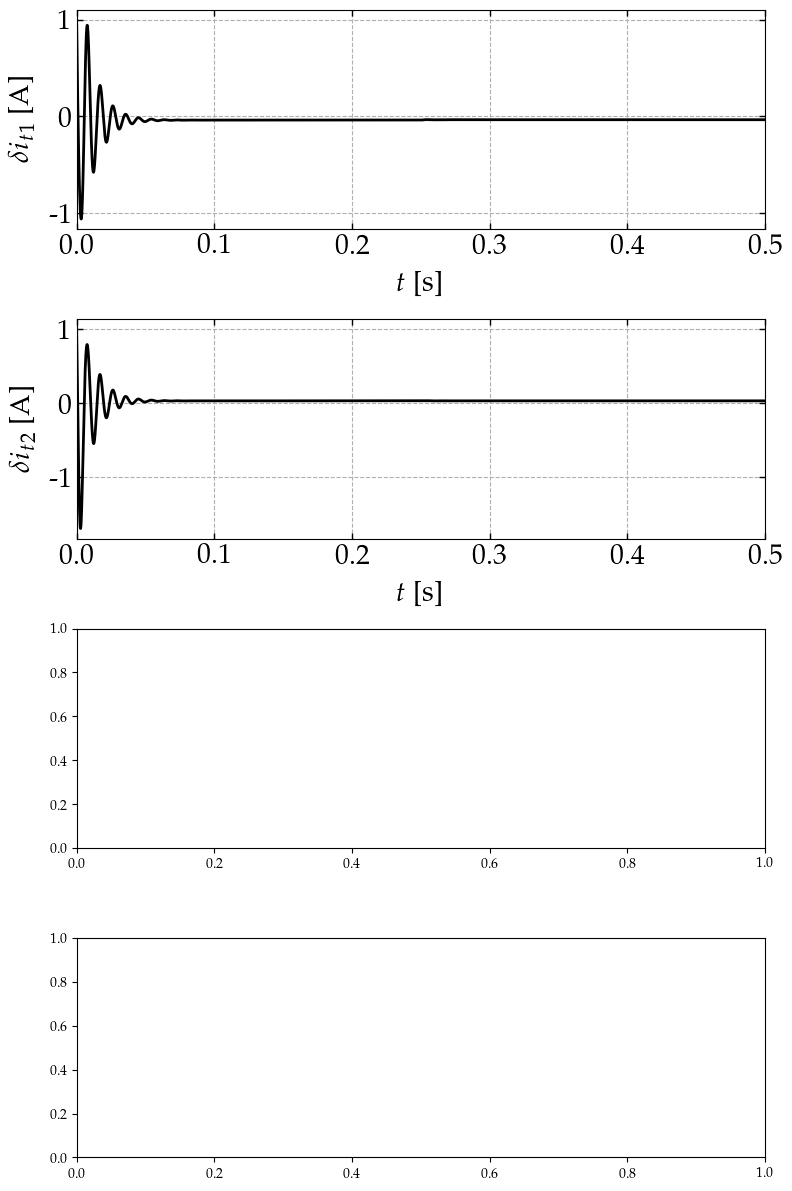

In [156]:
fig = plt.figure(figsize=(8, 12), layout='constrained')

mosaic = [['δit1'], ['δit2'], ['δit3'], ['δit4']]
axs = fig.subplot_mosaic(mosaic)

for i in range(dgs_amount, 2 * dgs_amount):
  gph.plot(axs[f'δit{i-dgs_amount+1}'], timepts, [v[i] for v in y],
           '$t$ [s]', f'$\\delta {{i_t}}_{i-dgs_amount+1}$ [A]',
           plot_cfg={**cfg,
                     'style': {**cfg['style']},
                     'axis': {**cfg['axis'], 'x_digits': t_decimal_places, 'y_digits': 0},
                     'limits': {**cfg['limits'], **axis_limits},
                     })

plt.tight_layout(pad=1.)

file_path = r"P:\Papers\PETC_for_Microgrids\Figs\inductor_currents.eps"
fig.savefig(file_path, format='eps', bbox_inches='tight', dpi=600)

Failed to find a Ghostscript installation.  Distillation step skipped.


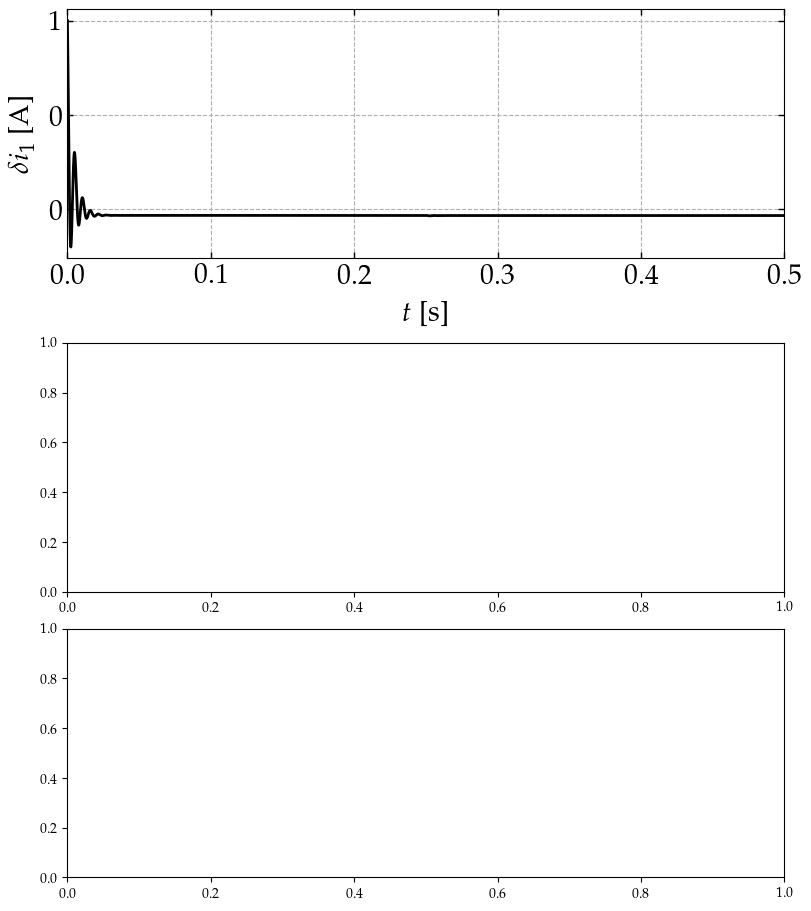

In [157]:
fig = plt.figure(figsize=(8, 9), layout='constrained')

mosaic = [['δi1'], ['δi2'], ['δv3']]
axs = fig.subplot_mosaic(mosaic)

for i in range(2 * dgs_amount, 2 * dgs_amount + lines):
  gph.plot(axs[mosaic[i - 2 * dgs_amount][0]], timepts, [v[i] for v in y],
           '$t$ [s]', f'$\\delta i_{i - 2 * dgs_amount + 1}$ [A]',
           plot_cfg={**cfg,
                     'style': {**cfg['style']},
                     'axis': {**cfg['axis'], 'x_digits': t_decimal_places, 'y_digits': 0},
                     'limits': {**cfg['limits'], **axis_limits},
                     })
file_path = r"P:\Papers\PETC_for_Microgrids\Figs\lines_currents.eps"
fig.savefig(file_path, format='eps', bbox_inches='tight', dpi=600)

C:\Users\andel\AppData\Local\Temp\ipykernel_23272\2834642358.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.)
Failed to find a Ghostscript installation.  Distillation step skipped.


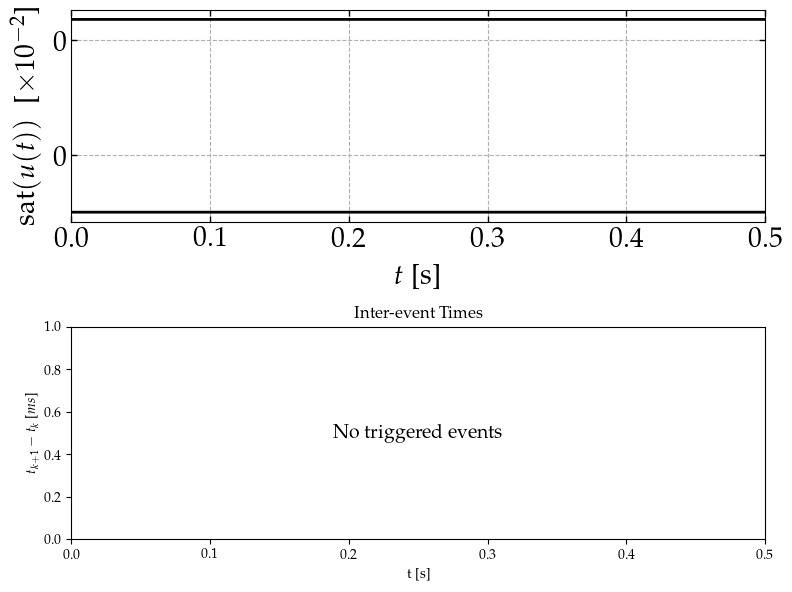

In [158]:
fig = plt.figure(figsize=(8, 6), layout='constrained')

mosaic = [['sat'], ['iet']]
axs = fig.subplot_mosaic(mosaic)

for i in range(dgs_amount):
  gph.plot(
      axs['sat'], t_formatted,
      [float(v[i]) * 1e2 for v in uc],
      xlabel='$t$ [s]', ylabel='sat$(u(t))\\;$ [$\\times 10^{-2}$]',
      plot_cfg={**cfg,
                'axis': {**cfg['axis'], 'x_digits': t_decimal_places,
                         'y_digits': 0},
                'limits': {**cfg['limits'], **axis_limits},
                'legend': {'fontsize': 16}
                })

# Plot dos IETs
if len(inter_event_times) > 0:
  stem_cfg = cfg.copy()
  stem_cfg['axis']['y_digits'] = 0

  gph.stem(
      axs['iet'], [et for et in event_times],
      [et * 1e3 for et in inter_event_times],
      xlabel='$t$ [s]', ylabel='$t_{k+1} - t_k\\;$ [ms]',
      stem_cfg={**cfg,
                'axis': {**cfg['axis'], 'x_digits': t_decimal_places,
                         'y_digits': 0},
                'limits': {'x_min': 0., 'x_max': timepts[-1]},
                })


else:
  axs['iet'].text(0.5, 0.5, 'No triggered events',
                  ha='center', va='center', fontsize=14,
                  transform=axs['iet'].transAxes)
  axs['iet'].set_title('Inter-event Times')
  axs['iet'].set_xlabel('t [s]')
  axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
  axs['iet'].set_xlim([0, simulation_time])
  axs['iet'].set_ylim([0, 1])  # valor simbólico
  axs['iet'].grid(False)

plt.tight_layout(pad=1.)
file_path = r"P:\Papers\PETC_for_Microgrids\Figs\control_signal_and_iet.eps"
fig.savefig(file_path, format='eps', bbox_inches='tight', dpi=600)